In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/road-accident-risk-prediction/sample_submission.csv
/kaggle/input/road-accident-risk-prediction/train.csv
/kaggle/input/road-accident-risk-prediction/test.csv


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Explorative data analysis 

In [3]:
train_df = pd.read_csv('/kaggle/input/road-accident-risk-prediction/train.csv')
train_df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [5]:
train_df.isnull().sum()

id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

In [6]:
train_df.nunique()

id                        517754
road_type                      3
num_lanes                      4
curvature                    261
speed_limit                    5
lighting                       3
weather                        3
road_signs_present             2
public_road                    2
time_of_day                    3
holiday                        2
school_season                  2
num_reported_accidents         8
accident_risk                 98
dtype: int64

In [7]:
print('Unique road types:', train_df['road_type'].unique())
print('Unique lightning conditions:', train_df['lighting'].unique())
print('Unique weather conditions:', train_df['weather'].unique())
print('Unique time of days:', train_df['time_of_day'].unique())

Unique road types: ['urban' 'rural' 'highway']
Unique lightning conditions: ['daylight' 'dim' 'night']
Unique weather conditions: ['rainy' 'clear' 'foggy']
Unique time of days: ['afternoon' 'evening' 'morning']


In [8]:
train_df.describe()

,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,258876.500000,2.491511,0.488719,46.112575,1.187970,0.352377
std,149462.849974,1.120434,0.272563,15.788521,0.895961,0.166417
min,0.000000,1.000000,0.000000,25.000000,0.000000,0.000000
25%,129438.250000,1.000000,0.260000,35.000000,1.000000,0.230000
50%,258876.500000,2.000000,0.510000,45.000000,1.000000,0.340000
75%,388314.750000,3.000000,0.710000,60.000000,2.000000,0.460000
max,517753.000000,4.000000,1.000000,70.000000,7.000000,1.000000


# Univariate analysis 

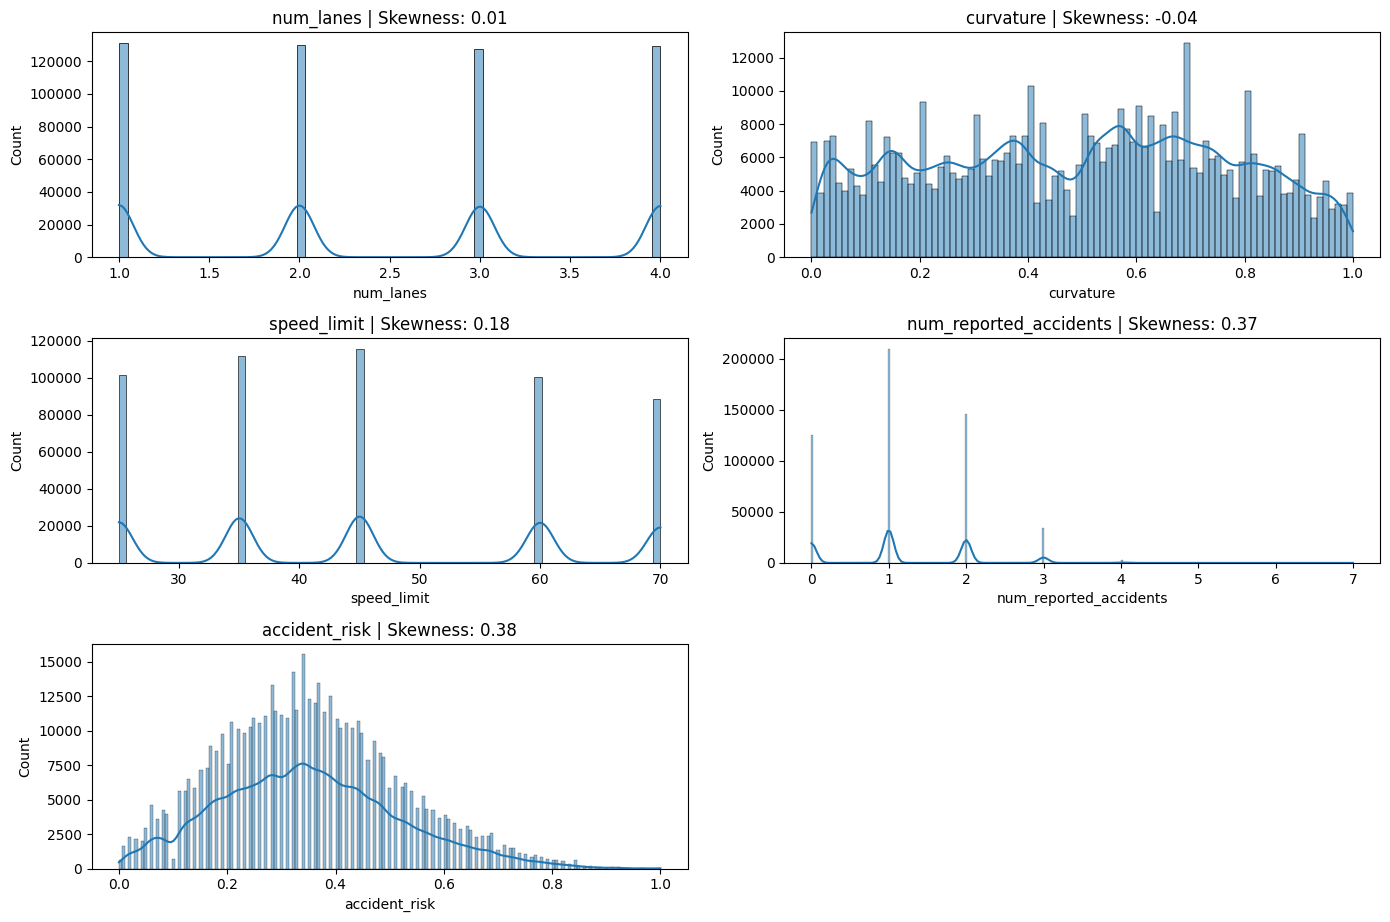

In [5]:
numerical_columns = train_df.select_dtypes(include=["int64", "float64"]).columns[1:]

plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(train_df[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(train_df[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

## Adding extra feature 

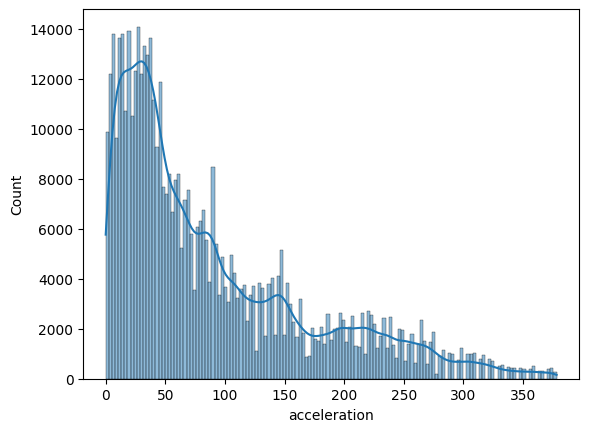

In [4]:
train_df['acceleration'] = ((train_df['speed_limit']/3.6) ** 2) * train_df['curvature']

sns.histplot(train_df, x = 'acceleration', kde=True)
plt.show()

# Multivariate analysis 

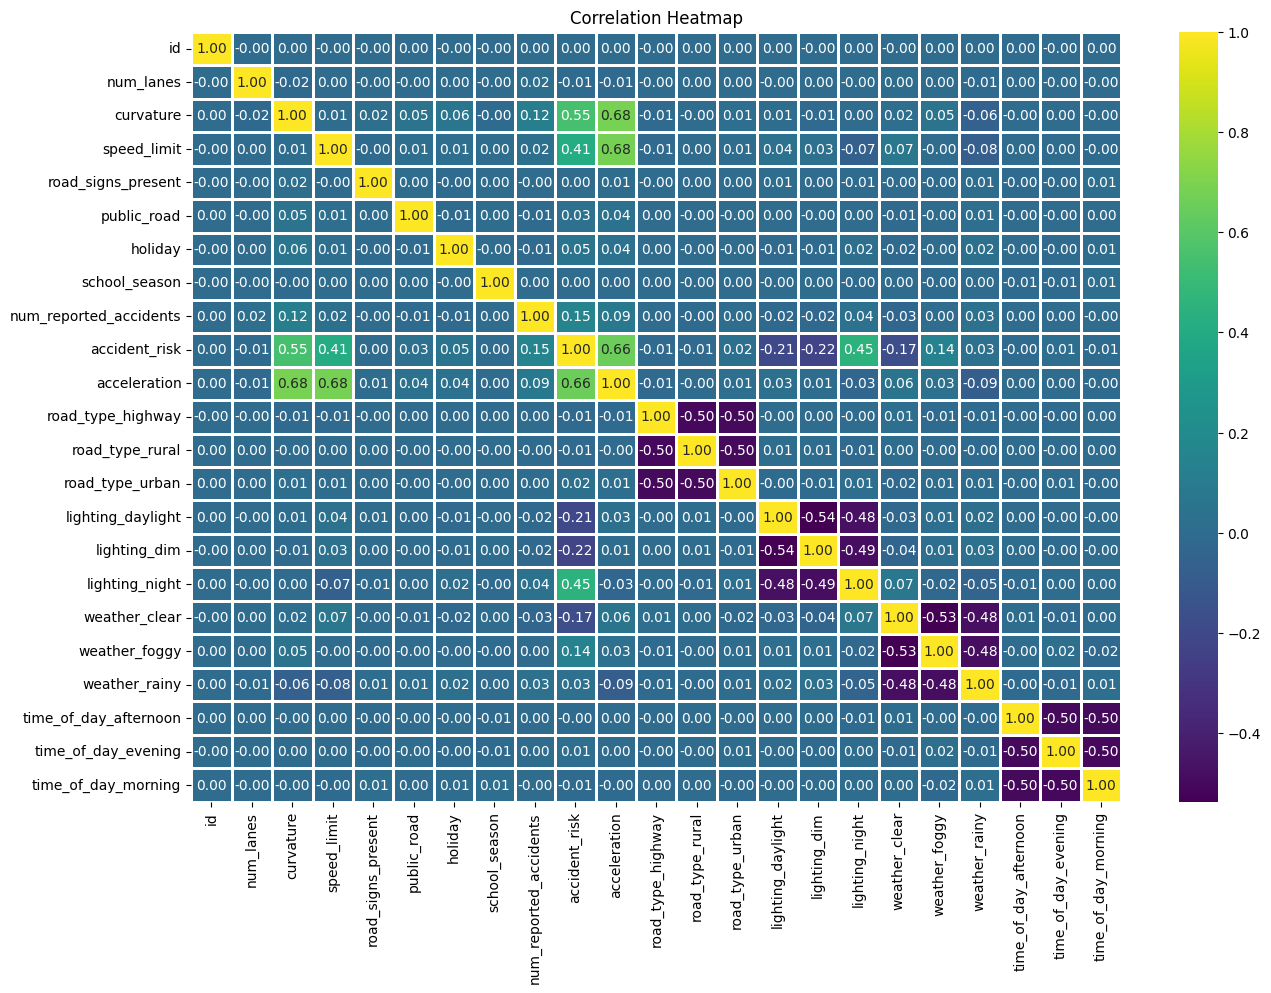

In [9]:
train_encoded = pd.get_dummies(train_df, drop_first=False, dtype=int)

plt.figure(figsize=(15, 10))

sns.heatmap(train_encoded.corr(method = 'spearman', numeric_only=True), annot=True, fmt='.2f', cmap='viridis', linewidths=2)

plt.title('Correlation Heatmap')
plt.show()

The multivariate analysis indicates that accident risk tends to increase on curved roads, at higher speed limits, and under nighttime lighting conditions. Conversely, risk decreases in clear weather and under daylight or dim lighting. These relationships suggest that both road geometry and environmental visibility are key factors in accident occurrence.

# Elastic net 

I want to try Elastic net as a base model as this model is a combination of Lasso and Ridge and allows to deal both with multicollinerity of the features as well as feature selection. 

<Axes: xlabel='acceleration_yeojohnson', ylabel='Count'>

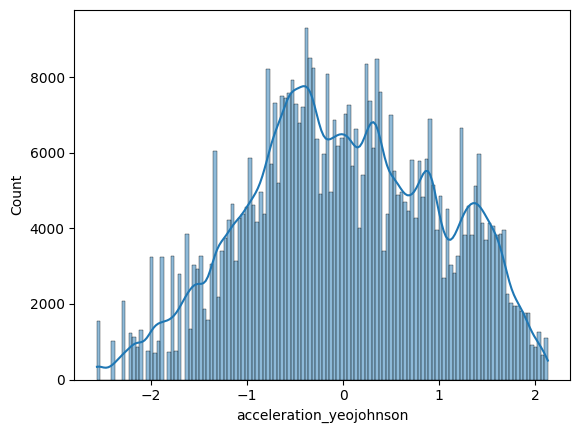

In [5]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson', standardize=True)
train_df['acceleration_yeojohnson'] = pt.fit_transform(train_df[['acceleration']])

sns.histplot(data=train_df, x='acceleration_yeojohnson', kde=True)

In [27]:
train_df.select_dtypes(include=["int64", "float64"]).columns.tolist()

['id',
 'num_lanes',
 'curvature',
 'speed_limit',
 'num_reported_accidents',
 'accident_risk',
 'acceleration',
 'acceleration_yeojohnson']

In [41]:
train_df.drop(columns = ['accident_risk'])

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,acceleration,acceleration_yeojohnson
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,5.671296,-1.690073
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,93.576389,0.395859
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,238.194444,1.490763
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,6.616512,-1.613717
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,161.111111,1.002607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517749,517749,highway,4,0.10,70,daylight,foggy,True,True,afternoon,False,False,2,37.808642,-0.453339
517750,517750,rural,4,0.47,35,daylight,rainy,True,True,morning,False,False,1,44.425154,-0.315865
517751,517751,urban,4,0.62,25,daylight,foggy,False,False,afternoon,False,True,0,29.899691,-0.643579
517752,517752,highway,3,0.63,25,night,clear,True,False,afternoon,True,True,3,30.381944,-0.630971


In [11]:
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV, ElasticNet


categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = train_df.select_dtypes(include=["int64", "float64"]).columns[1:].tolist()
numerical_cols.remove('num_lanes')
numerical_cols.remove('acceleration')
numerical_cols.remove('acceleration_yeojohnson')
numerical_cols.remove('accident_risk')

ct = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols + ['num_lanes']), 
        ('special', PowerTransformer(method='yeo-johnson', standardize=True), ['acceleration']), 
        
    ], force_int_remainder_cols=False
)


model = Pipeline(steps=[
    ('preprocess', ct),
    ('reg', ElasticNetCV(cv=5, random_state=99))
])

X_train, X_valid, y_train, y_valid = train_test_split(
    train_df.drop(columns = ['accident_risk', 'id', 'acceleration_yeojohnson']), train_df['accident_risk'], test_size=0.2, random_state=42)

model.fit(X_train, y_train)



Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   transformers=[('num', StandardScaler(),
                                                  ['curvature', 'speed_limit',
                                                   'num_reported_accidents']),
                                                 ('cat', OneHotEncoder(),
                                                  ['road_type', 'lighting',
                                                   'weather', 'time_of_day',
                                                   'num_lanes']),
                                                 ('special', PowerTransformer(),
                                                  ['acceleration'])])),
                ('reg', ElasticNetCV(cv=5, random_state=99))])

In [15]:
reg = model.named_steps['reg']   # ElasticNetCV object

best_alpha = reg.alpha_
best_l1_ratio = reg.l1_ratio_

print("Best alpha:", reg.alpha_)
print("Best l1_ratio:", reg.l1_ratio_)
print("All tried alphas:", reg.alphas_)
print("All tried l1_ratios:", reg.l1_ratio if hasattr(reg, "l1_ratio") else reg.l1_ratio_)

Best alpha: 0.00021990535820696005
Best l1_ratio: 0.5
All tried alphas: [0.21990536 0.20508447 0.19126247 0.17837202 0.16635034 0.15513888
 0.14468304 0.13493189 0.12583793 0.11735688 0.10944741 0.10207103
 0.09519178 0.08877617 0.08279296 0.07721299 0.07200909 0.06715592
 0.06262983 0.05840879 0.05447224 0.05080099 0.04737717 0.04418411
 0.04120625 0.03842909 0.03583909 0.03342366 0.03117102 0.02907019
 0.02711096 0.02528377 0.02357973 0.02199054 0.02050845 0.01912625
 0.0178372  0.01663503 0.01551389 0.0144683  0.01349319 0.01258379
 0.01173569 0.01094474 0.0102071  0.00951918 0.00887762 0.0082793
 0.0077213  0.00720091 0.00671559 0.00626298 0.00584088 0.00544722
 0.0050801  0.00473772 0.00441841 0.00412062 0.00384291 0.00358391
 0.00334237 0.0031171  0.00290702 0.0027111  0.00252838 0.00235797
 0.00219905 0.00205084 0.00191262 0.00178372 0.0016635  0.00155139
 0.00144683 0.00134932 0.00125838 0.00117357 0.00109447 0.00102071
 0.00095192 0.00088776 0.00082793 0.00077213 0.00072009 0.

In [13]:
elastic_net_model = Pipeline(steps=[
    ('preprocess', ct),
    ('reg', ElasticNet(alpha =  0.000219, l1_ratio = 0.5))
])
elastic_net_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   transformers=[('num', StandardScaler(),
                                                  ['curvature', 'speed_limit',
                                                   'num_reported_accidents']),
                                                 ('cat', OneHotEncoder(),
                                                  ['road_type', 'lighting',
                                                   'weather', 'time_of_day',
                                                   'num_lanes']),
                                                 ('special', PowerTransformer(),
                                                  ['acceleration'])])),
                ('reg', ElasticNet(alpha=0.000219))])

In [9]:
y_pred = elastic_net_model.predict(X_valid)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

MSE: 0.005376555063532347
RMSE: 0.07332499617137628
MAE: 0.05813662017547848
R²: 0.8052833102641693


Elastic net gave me an RMSE of 0.07 which is much smaller than the standard deviation of the accident risk. 

In [20]:
test_df = pd.read_csv('/kaggle/input/road-accident-risk-prediction/test.csv')
test_df['acceleration'] = ((test_df['speed_limit']/3.6) ** 2) * test_df['curvature']
X_test = test_df.drop(columns = ['id'])
y_test_pred = elastic_net_model.predict(X_test)
pd.DataFrame({'id': test_df['id'], 'accident_risk': y_test_pred}).to_csv('/kaggle/working/elastic_net_test.csv', index = False)


# Result on a test set: 0.07329

# Catboost 

In [18]:
from catboost import CatBoostRegressor
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_features =  categorical_cols + ['num_lanes']

X_train, X_valid, y_train, y_valid = train_test_split(
    train_df.drop(columns = ['accident_risk', 'id', 'acceleration']), train_df['accident_risk'], test_size=0.2, random_state=42)

catmodel = CatBoostRegressor(iterations=200, learning_rate=0.1, depth=6)
catmodel.fit(X_train, y_train, cat_features=cat_features)

0:	learn: 0.1534897	total: 318ms	remaining: 1m 3s
1:	learn: 0.1421912	total: 611ms	remaining: 1m
2:	learn: 0.1311486	total: 873ms	remaining: 57.3s
3:	learn: 0.1215385	total: 1.11s	remaining: 54.6s
4:	learn: 0.1131022	total: 1.34s	remaining: 52.4s
5:	learn: 0.1059718	total: 1.55s	remaining: 50.3s
6:	learn: 0.0991925	total: 1.77s	remaining: 48.9s
7:	learn: 0.0933551	total: 1.99s	remaining: 47.8s
8:	learn: 0.0881661	total: 2.25s	remaining: 47.8s
9:	learn: 0.0837345	total: 2.51s	remaining: 47.6s
10:	learn: 0.0798426	total: 2.74s	remaining: 47s
11:	learn: 0.0764629	total: 3s	remaining: 47s
12:	learn: 0.0734656	total: 3.2s	remaining: 46.1s
13:	learn: 0.0710349	total: 3.46s	remaining: 45.9s
14:	learn: 0.0687880	total: 3.68s	remaining: 45.4s
15:	learn: 0.0669477	total: 3.88s	remaining: 44.6s
16:	learn: 0.0653551	total: 4.06s	remaining: 43.7s
17:	learn: 0.0640588	total: 4.32s	remaining: 43.7s
18:	learn: 0.0629789	total: 4.59s	remaining: 43.7s
19:	learn: 0.0620485	total: 4.86s	remaining: 43.7s
2

In [19]:
importances = catmodel.feature_importances_
feat_importances = pd.Series(importances, index=X_train.columns)

print(feat_importances.sort_values(ascending=False).head(20))

lighting                   42.914702
speed_limit                18.918540
curvature                  17.482342
weather                    11.581526
num_reported_accidents      5.068279
acceleration_yeojohnson     3.968959
holiday                     0.032657
public_road                 0.021046
road_signs_present          0.004551
time_of_day                 0.003546
road_type                   0.002140
num_lanes                   0.001119
school_season               0.000595
dtype: float64


In [33]:
y_pred = catmodel.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
print(rmse)

0.05625858347471523


In [28]:
test_df['acceleration'] = ((test_df['speed_limit']/3.6) ** 2) * test_df['curvature']
X_test = test_df.drop(columns = ['id'])
y_test_pred = catboost_model.predict(X_test)
pd.DataFrame({'id': test_df['id'], 'accident_risk': y_test_pred}).to_csv('/kaggle/working/catboost_test.csv', index = False)

# Result on a test set: 0.0558

## Parameter search Catboost 

In [25]:
from catboost import CatBoostRegressor, Pool


model = CatBoostRegressor()
grid = {'learning_rate': [0.03,0.05,0.07, 0.1, 0.15],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

randomized_search_result = model.randomized_search(grid,
                                                   X= Pool(X_train, y_train, cat_features=cat_features))

0:	learn: 0.3652202	test: 0.3651538	best: 0.3651538 (0)	total: 194ms	remaining: 3m 14s
1:	learn: 0.3423267	test: 0.3422763	best: 0.3422763 (1)	total: 376ms	remaining: 3m 7s
2:	learn: 0.3210664	test: 0.3210204	best: 0.3210204 (2)	total: 546ms	remaining: 3m 1s
3:	learn: 0.3017132	test: 0.3016746	best: 0.3016746 (3)	total: 692ms	remaining: 2m 52s
4:	learn: 0.2835989	test: 0.2835670	best: 0.2835670 (4)	total: 854ms	remaining: 2m 50s
5:	learn: 0.2669244	test: 0.2669006	best: 0.2669006 (5)	total: 1s	remaining: 2m 46s
6:	learn: 0.2517672	test: 0.2517448	best: 0.2517448 (6)	total: 1.16s	remaining: 2m 45s
7:	learn: 0.2362793	test: 0.2362850	best: 0.2362850 (7)	total: 1.33s	remaining: 2m 45s
8:	learn: 0.2218627	test: 0.2218957	best: 0.2218957 (8)	total: 1.48s	remaining: 2m 42s
9:	learn: 0.2085239	test: 0.2085738	best: 0.2085738 (9)	total: 1.61s	remaining: 2m 39s
10:	learn: 0.1959537	test: 0.1960088	best: 0.1960088 (10)	total: 1.74s	remaining: 2m 36s
11:	learn: 0.1845028	test: 0.1845767	best: 0.1

KeyboardInterrupt: 